# Notebook 1 — Préparation & Nettoyage des Données
## P11 — Étude de marché : Disponibilité alimentaire mondiale (2017)
---
**Objectif :** Charger, nettoyer, enrichir (feature engineering) et exporter un DataFrame prêt pour l'analyse multivariée et le clustering.

**Données source :**
- `DisponibiliteAlimentaire_2017.xlsx` — Bilans alimentaires FAO, 174 pays
- `Population_2000_2018.csv` — Population estimée par pays (2000–2018)


---
## 1. Importation des bibliothèques et chargement des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Style des graphiques
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook', font_scale=1.1)

# --- Chargement des données ---
df_alim = pd.read_excel('DisponibiliteAlimentaire_2017.xlsx')
df_pop  = pd.read_csv('Population_2000_2018.csv')

print(f"DisponibiliteAlimentaire : {df_alim.shape[0]} lignes, {df_alim.shape[1]} colonnes")
print(f"Population               : {df_pop.shape[0]} lignes, {df_pop.shape[1]} colonnes")
print(f"\nPays dans l'alimentaire : {df_alim['Zone'].nunique()}")
print(f"Années dans Population  : {sorted(df_pop['Année'].unique())}")

DisponibiliteAlimentaire : 176600 lignes, 14 colonnes
Population               : 4411 lignes, 15 colonnes

Pays dans l'alimentaire : 174
Années dans Population  : [np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018)]


### 1.1 — Aperçu rapide des deux fichiers

In [2]:
print("=== DisponibiliteAlimentaire_2017 ===")
print(f"Éléments disponibles ({df_alim['Élément'].nunique()}) :")
for e in df_alim['Élément'].unique():
    print(f"  • {e}")
print(f"\nProduits alimentaires : {df_alim['Produit'].nunique()}")
print(f"Année : {df_alim['Année'].unique()}")
df_alim.head(3)

=== DisponibiliteAlimentaire_2017 ===
Éléments disponibles (17) :
  • Production
  • Importations - Quantité
  • Variation de stock
  • Exportations - Quantité
  • Disponibilité intérieure
  • Aliments pour animaux
  • Semences
  • Pertes
  • Résidus
  • Nourriture
  • Disponibilité alimentaire en quantité (kg/personne/an)
  • Disponibilité alimentaire (Kcal/personne/jour)
  • Disponibilité de protéines en quantité (g/personne/jour)
  • Disponibilité de matière grasse en quantité (g/personne/jour)
  • Traitement
  • Autres utilisations (non alimentaire)
  • Alimentation pour touristes

Produits alimentaires : 98
Année : [2017]


,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5511,Production,2511,Blé et produits,2017,2017,Milliers de tonnes,4281.0,S,Données standardisées
1,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5611,Importations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,2302.0,S,Données standardisées
2,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5072,Variation de stock,2511,Blé et produits,2017,2017,Milliers de tonnes,-119.0,S,Données standardisées


In [3]:
print("=== Population_2000_2018 ===")
print(f"Zones (pays/territoires) : {df_pop['Zone'].nunique()}")
print(f"Élément unique : {df_pop['Élément'].unique()}")
print(f"Unité : {df_pop['Unité'].unique()}")
df_pop.head(3)

=== Population_2000_2018 ===
Zones (pays/territoires) : 238
Élément unique : ['Population totale']
Unité : ['1000 personnes']


,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2000,2000,1000 personnes,20779.953,X,Sources internationales sûres,NaN
1,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2001,2001,1000 personnes,21606.988,X,Sources internationales sûres,NaN
2,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2002,2002,1000 personnes,22600.770,X,Sources internationales sûres,NaN


---
## 2. Extraction de la population 2017

On filtre la population pour l'année **2017** uniquement, afin de la joindre au fichier alimentaire qui est également sur 2017.

In [4]:
# Filtrer sur 2017 et renommer
pop_2017 = (
    df_pop[df_pop['Année'] == 2017]
    [['Zone', 'Valeur']]
    .rename(columns={'Valeur': 'Population_1000'})
    .reset_index(drop=True)
)

print(f"Population 2017 : {len(pop_2017)} pays/territoires")
print(f"Unité : 1000 personnes\n")
pop_2017.head()

Population 2017 : 236 pays/territoires
Unité : 1000 personnes



,Zone,Population_1000
0,Afghanistan,36296.113
1,Afrique du Sud,57009.756
2,Albanie,2884.169
3,Algérie,41389.189
4,Allemagne,82658.409


---
## 3. Sélection et agrégation des variables

### Stratégie
Le fichier alimentaire contient des données **détaillées par produit** (ex : blé, riz, viande…).
Pour un clustering **par pays**, on a besoin de variables **macroéconomiques agrégées**.

On sélectionne les éléments suivants et on les **agrège (somme) sur tous les produits** pour obtenir un indicateur global par pays :

| # | Variable choisie | Justification |
|---|-----------------|---------------|
| 1 | Disponibilité alimentaire (Kcal/personne/jour) | Indicateur central de sécurité alimentaire |
| 2 | Disponibilité alimentaire en quantité (kg/personne/an) | Volume alimentaire disponible |
| 3 | Disponibilité de matière grasse (g/personne/jour) | Équilibre nutritionnel — lipides |
| 4 | Disponibilité de protéines (g/personne/jour) | Équilibre nutritionnel — protéines |
| 5 | Production | Capacité agricole nationale |
| 6 | Importations — Quantité | Dépendance alimentaire extérieure |
| 7 | Exportations — Quantité | Exportation de ressources alimentaires |
| 8 | Pertes | Efficacité de la chaîne d'approvisionnement |
| 9 | Nourriture | Quantité effectivement consommée |
| 10 | Disponibilité intérieure | Total disponible après flux commerciaux |
| 11 | Variation de stock | Dynamique des réserves alimentaires |
| 12 | Aliments pour animaux | Part de la production destinée à l'élevage |
| + | Population (2017) | Variable de pondération pour les ratios |

> **Note :** Les 4 variables "par personne" (Kcal, kg, g de gras, g de protéines) sont déjà agrégées par la FAO — on les moyenne plutôt qu'on les somme.

In [5]:
# Variables à SOMME (volumes totaux par pays)
vars_somme = [
    'Production',
    'Importations - Quantité',
    'Exportations - Quantité',
    'Pertes',
    'Nourriture',
    'Disponibilité intérieure',
    'Variation de stock',
    'Aliments pour animaux',
]

# Variables à MOYENNE (déjà "par personne")
vars_moyenne = [
    'Disponibilité alimentaire (Kcal/personne/jour)',
    'Disponibilité alimentaire en quantité (kg/personne/an)',
    'Disponibilité de matière grasse en quantité (g/personne/jour)',
    'Disponibilité de protéines en quantité (g/personne/jour)',
]

# --- Agrégation somme ---
dfs = []
for var in vars_somme:
    sub = (
        df_alim[df_alim['Élément'] == var]
        .groupby('Zone')['Valeur']
        .sum()
        .reset_index()
        .rename(columns={'Valeur': var})
    )
    dfs.append(sub)

# --- Agrégation moyenne ---
for var in vars_moyenne:
    sub = (
        df_alim[df_alim['Élément'] == var]
        .groupby('Zone')['Valeur']
        .mean()
        .reset_index()
        .rename(columns={'Valeur': var})
    )
    dfs.append(sub)

# --- Fusion itérative ---
df_pays = dfs[0]
for d in dfs[1:]:
    df_pays = df_pays.merge(d, on='Zone', how='outer')

print(f"DataFrame agrégé : {df_pays.shape[0]} pays, {df_pays.shape[1]} colonnes")
df_pays.head()

DataFrame agrégé : 174 pays, 13 colonnes


,Zone,Production,Importations - Quantité,Exportations - Quantité,Pertes,Nourriture,Disponibilité intérieure,Variation de stock,Aliments pour animaux,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité de matière grasse en quantité (g/personne/jour),Disponibilité de protéines en quantité (g/personne/jour)
0,Afghanistan,11609.0,4555.0,601.0,1146.0,12968.0,15139.0,426.0,456.0,32.209677,5.254559,0.486190,0.858571
1,Afrique du Sud,68455.0,9020.0,10968.0,3108.0,31726.0,66840.0,-322.0,9371.0,34.333333,6.395632,0.941609,0.958161
2,Albanie,4231.0,884.0,156.0,321.0,3631.0,4879.0,72.0,697.0,43.589744,16.160128,1.507308,1.532051
3,Algérie,26763.0,19718.0,743.0,3683.0,33056.0,45365.0,374.0,4884.0,39.821429,9.508452,0.947857,1.105357
4,Allemagne,167828.0,66550.0,58793.0,5756.0,77988.0,174960.0,651.0,30904.0,40.908046,10.841839,1.700690,1.196207


---
## 4. Jointure avec la population 2017

In [6]:
# Inner join : on ne garde que les pays présents DANS LES DEUX fichiers
df = df_pays.merge(pop_2017, on='Zone', how='inner')

print(f"Après jointure : {len(df)} pays")
print(f"Colonnes : {df.columns.tolist()}")
df.head()

Après jointure : 174 pays
Colonnes : ['Zone', 'Production', 'Importations - Quantité', 'Exportations - Quantité', 'Pertes', 'Nourriture', 'Disponibilité intérieure', 'Variation de stock', 'Aliments pour animaux', 'Disponibilité alimentaire (Kcal/personne/jour)', 'Disponibilité alimentaire en quantité (kg/personne/an)', 'Disponibilité de matière grasse en quantité (g/personne/jour)', 'Disponibilité de protéines en quantité (g/personne/jour)', 'Population_1000']


,Zone,Production,Importations - Quantité,Exportations - Quantité,Pertes,Nourriture,Disponibilité intérieure,Variation de stock,Aliments pour animaux,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité de matière grasse en quantité (g/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Population_1000
0,Afghanistan,11609.0,4555.0,601.0,1146.0,12968.0,15139.0,426.0,456.0,32.209677,5.254559,0.486190,0.858571,36296.113
1,Afrique du Sud,68455.0,9020.0,10968.0,3108.0,31726.0,66840.0,-322.0,9371.0,34.333333,6.395632,0.941609,0.958161,57009.756
2,Albanie,4231.0,884.0,156.0,321.0,3631.0,4879.0,72.0,697.0,43.589744,16.160128,1.507308,1.532051,2884.169
3,Algérie,26763.0,19718.0,743.0,3683.0,33056.0,45365.0,374.0,4884.0,39.821429,9.508452,0.947857,1.105357,41389.189
4,Allemagne,167828.0,66550.0,58793.0,5756.0,77988.0,174960.0,651.0,30904.0,40.908046,10.841839,1.700690,1.196207,82658.409


---
## 5. Vérification des données & gestion des valeurs manquantes

In [7]:
print("=== Valeurs manquantes ===")
nulls = df.isnull().sum()
print(nulls[nulls > 0])

print(f"\n=== Pays avec au moins 1 valeur manquante ===")
mask_null = df.isnull().any(axis=1)
print(df[mask_null]['Zone'].tolist())

print(f"\nPays complets (0 null) : {(~mask_null).sum()}")
print(f"Pays avec nulls        : {mask_null.sum()}")

=== Valeurs manquantes ===
Pertes                                                           4
Disponibilité alimentaire (Kcal/personne/jour)                   2
Disponibilité alimentaire en quantité (kg/personne/an)           2
Disponibilité de matière grasse en quantité (g/personne/jour)    2
Disponibilité de protéines en quantité (g/personne/jour)         2
dtype: int64

=== Pays avec au moins 1 valeur manquante ===
['Bermudes', 'Brunéi Darussalam', 'Ouzbékistan', 'République démocratique populaire lao']

Pays complets (0 null) : 170
Pays avec nulls        : 4


In [8]:
# On supprime les 4 pays avec des valeurs manquantes
# Justification : < 2.5% du total, et ces pays sont des cas particuliers
#   - Bermudes, Brunei : données per-capita totalement absentes (territoires très spécifiques)
#   - Ouzbékistan, Lao PDR : uniquement 'Pertes' manquante

pays_supprimés = df[mask_null]['Zone'].tolist()
df = df.dropna().reset_index(drop=True)

print(f"Pays supprimés : {pays_supprimés}")
print(f"DataFrame final : {len(df)} pays, {df.shape[1]} colonnes")
print(f"Valeurs manquantes restantes : {df.isnull().sum().sum()}")

Pays supprimés : ['Bermudes', 'Brunéi Darussalam', 'Ouzbékistan', 'République démocratique populaire lao']
DataFrame final : 170 pays, 14 colonnes
Valeurs manquantes restantes : 0


---
## 6. Description des données & détection des outliers

In [9]:
print("=== Statistiques descriptives ===")
df.describe().T

=== Statistiques descriptives ===


,count,mean,std,min,25%,50%,75%,max
Production,170.0,66276.711765,226037.992272,21.000000,2321.000000,10770.000000,32636.250000,2.147703e+06
Importations - Quantité,170.0,8700.723529,20005.442305,26.000000,824.250000,2671.500000,7778.250000,2.059030e+05
Exportations - Quantité,170.0,9350.947059,24042.890249,0.000000,178.000000,874.000000,7207.500000,2.072780e+05
Pertes,170.0,3599.170588,14053.718805,0.000000,156.750000,597.500000,2078.750000,1.296670e+05
Nourriture,170.0,30827.958824,122064.739703,23.000000,1856.250000,6407.500000,17820.750000,1.376284e+06
Disponibilité intérieure,170.0,64984.223529,226195.631105,50.000000,3033.250000,12091.500000,33349.500000,2.303613e+06
Variation de stock,170.0,665.794118,3719.265267,-9121.000000,-17.750000,70.500000,508.000000,4.102500e+04
Aliments pour animaux,170.0,8916.482353,35088.356052,0.000000,239.250000,1297.000000,5091.250000,4.112640e+05
Disponibilité alimentaire (Kcal/personne/jour),170.0,34.011683,5.695308,19.931818,29.820225,33.477011,38.847370,4.542169e+01
Disponibilité alimentaire en quantité (kg/personne/an),170.0,8.158404,2.496879,3.437159,6.314020,7.871667,10.498033,1.616013e+01


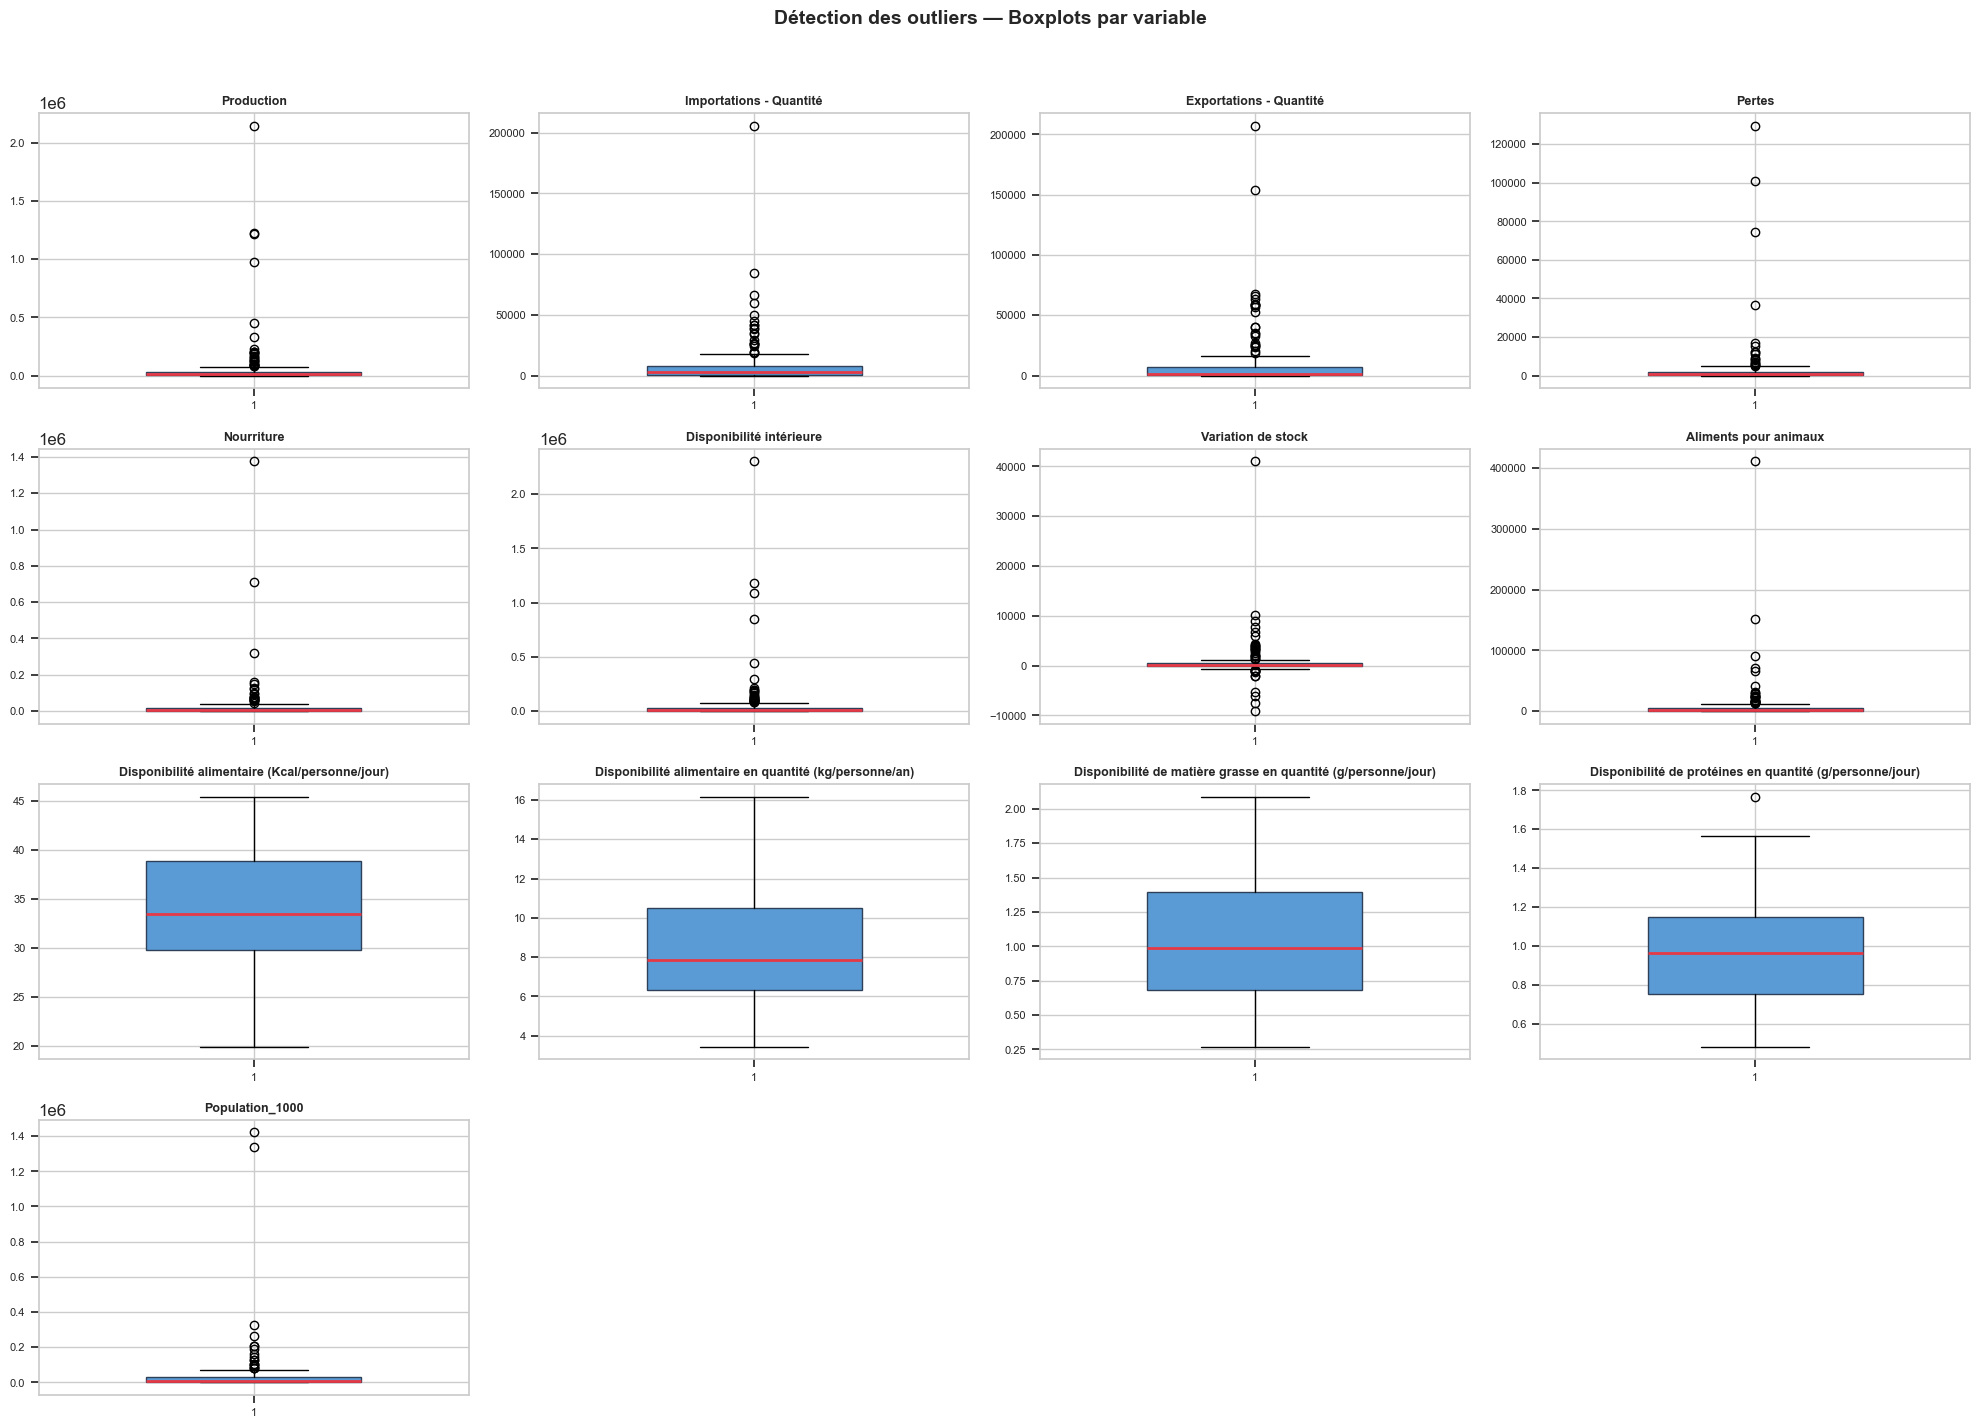

In [10]:
# Boxplots pour visualiser les outliers sur chaque variable numérique
cols_num = [c for c in df.columns if c != 'Zone']

fig, axes = plt.subplots(4, 4, figsize=(20, 14))
axes = axes.flatten()

for i, col in enumerate(cols_num):
    axes[i].boxplot(df[col], vert=True, widths=0.5,
                    patch_artist=True,
                    boxprops=dict(facecolor='#5B9BD5', color='#2E4057'),
                    medianprops=dict(color='#E63946', linewidth=2))
    axes[i].set_title(col, fontsize=9, fontweight='bold')
    axes[i].tick_params(labelsize=8)

# Cacher les axes non utilisés
for j in range(len(cols_num), len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Détection des outliers — Boxplots par variable', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [11]:
# Quantification des outliers par méthode IQR
print("=== Nombre d'outliers par variable (méthode IQR) ===")
print(f"{'Variable':<65} {'Outliers':>8} {'% du total':>10}")
print('─' * 85)

for col in cols_num:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    n_out = ((df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)).sum()
    pct = n_out / len(df) * 100
    print(f"{col:<65} {n_out:>8} {pct:>9.1f}%")

print("\n> Les outliers sont gardés : ils représentent des pays réels (Chine, Inde, etc.)")
print("> Ils seront naturellement géréss par le centrage-réduction avant l'ACP.")

=== Nombre d'outliers par variable (méthode IQR) ===
Variable                                                          Outliers % du total
─────────────────────────────────────────────────────────────────────────────────────
Production                                                              27      15.9%
Importations - Quantité                                                 21      12.4%
Exportations - Quantité                                                 23      13.5%
Pertes                                                                  18      10.6%
Nourriture                                                              21      12.4%
Disponibilité intérieure                                                28      16.5%
Variation de stock                                                      36      21.2%
Aliments pour animaux                                                   25      14.7%
Disponibilité alimentaire (Kcal/personne/jour)                           0       0.0%
D

---
## 7. Feature Engineering — Création de nouvelles variables

On crée **4 nouvelles variables** (ratios et indicateurs) pour enrichir le modèle :

| Variable créée | Formule | Interprétation |
|---|---|---|
| `Taux_dependance_alimentaire` | Importations / Disponibilité intérieure | Part des besoins couverte par l'extérieur |
| `Ratio_pertes` | Pertes / Disponibilité intérieure | Inefficacité de la chaîne d'approvisionnement |
| `Production_par_capita` | Production / Population | Productivité agricole nationale |
| `Ratio_export_import` | Exportations / Importations | Position commerciale nette en alimentation |

In [12]:
# On évite la division par zéro avec un petit epsilon
eps = 0.001

df['Taux_dependance_alimentaire'] = (
    df['Importations - Quantité'] / (df['Disponibilité intérieure'] + eps)
)

df['Ratio_pertes'] = (
    df['Pertes'] / (df['Disponibilité intérieure'] + eps)
)

df['Production_par_capita'] = (
    df['Production'] / (df['Population_1000'] + eps)
)

df['Ratio_export_import'] = (
    df['Exportations - Quantité'] / (df['Importations - Quantité'] + eps)
)

print(f"Nouvelles variables créées : 4")
print(f"Total variables numériques : {len([c for c in df.columns if c != 'Zone'])}")
print(f"\nDimensions finale du DataFrame : {df.shape}")
df[['Zone','Taux_dependance_alimentaire','Ratio_pertes',
    'Production_par_capita','Ratio_export_import']].head(10)

Nouvelles variables créées : 4
Total variables numériques : 17

Dimensions finale du DataFrame : (170, 18)


,Zone,Taux_dependance_alimentaire,Ratio_pertes,Production_par_capita,Ratio_export_import
0,Afghanistan,0.300879,0.075699,0.319841,0.131943
1,Afrique du Sud,0.134949,0.046499,1.200759,1.215964
2,Albanie,0.181185,0.065792,1.466973,0.176470
3,Algérie,0.434652,0.081186,0.646618,0.037681
4,Allemagne,0.380373,0.032899,2.030380,0.883441
5,Angola,0.128935,0.117821,0.956609,0.014447
6,Antigua-et-Barbuda,0.845228,0.011905,0.241022,0.000000
7,Arabie saoudite,0.815171,0.024782,0.273011,0.084841
8,Argentine,0.024511,0.027005,4.653921,18.764076
9,Arménie,0.193018,0.062514,1.259172,0.288416


In [13]:
# Statistiques sur les nouvelles variables
new_vars = ['Taux_dependance_alimentaire','Ratio_pertes',
            'Production_par_capita','Ratio_export_import']
df[new_vars].describe().T

,count,mean,std,min,25%,50%,75%,max
Taux_dependance_alimentaire,170.0,0.332267,0.294073,0.009879,0.109058,0.226313,0.481431,1.520410
Ratio_pertes,170.0,0.051738,0.035934,0.000000,0.029661,0.045562,0.065673,0.302613
Production_par_capita,170.0,1.519084,1.316087,0.033730,0.560602,1.135567,1.880129,6.396659
Ratio_export_import,170.0,1.334357,2.884313,0.000000,0.157301,0.405768,1.209293,21.907921


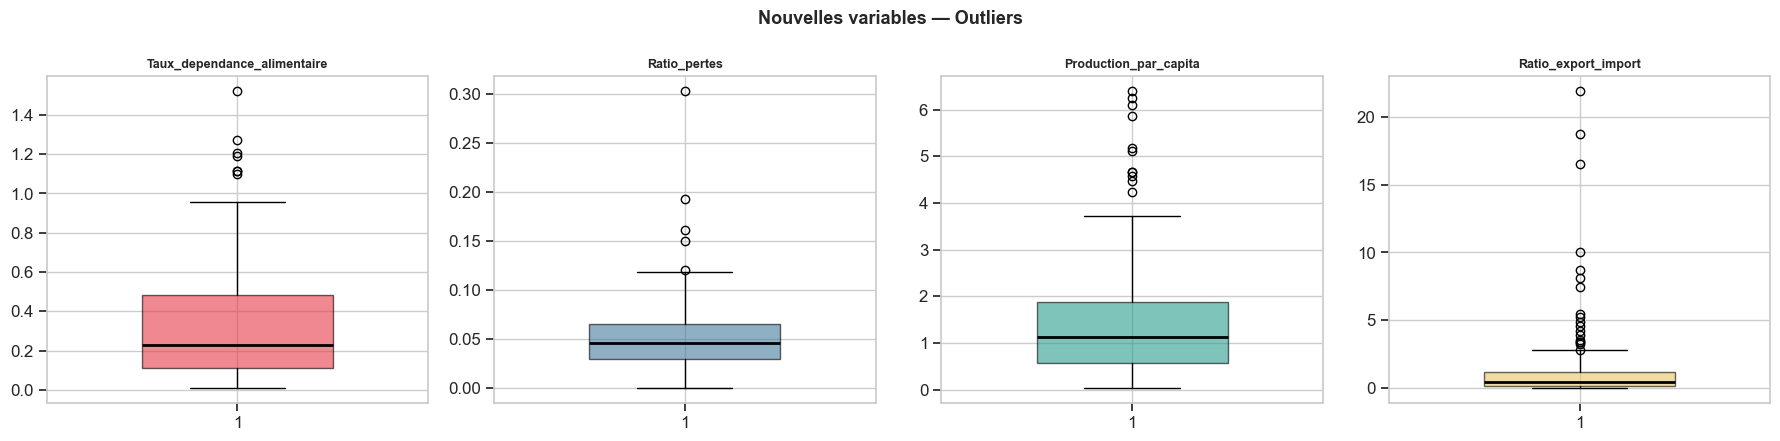

In [14]:
# Boxplots des nouvelles variables
fig, axes = plt.subplots(1, 4, figsize=(18, 4.5))

colors = ['#E63946','#457B9D','#2A9D8F','#E9C46A']
for i, (var, color) in enumerate(zip(new_vars, colors)):
    axes[i].boxplot(df[var], vert=True, widths=0.5,
                    patch_artist=True,
                    boxprops=dict(facecolor=color, alpha=0.6),
                    medianprops=dict(color='black', linewidth=2))
    axes[i].set_title(var, fontsize=9, fontweight='bold')

plt.suptitle('Nouvelles variables — Outliers', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 8. Résumé final & export

Le DataFrame est prêt pour le Notebook 2 (analyse multivariée + ACP + clustering).

In [15]:
print("=" * 60)
print(" RÉSUMÉ — DONNÉES PRÊTES POUR L'ANALYSE")
print("=" * 60)
print(f"  • Nombre de pays       : {len(df)}")
print(f"  • Variables originales : 12 + Population")
print(f"  • Variables engineered : 4")
print(f"  • Total variables num. : {len([c for c in df.columns if c != 'Zone'])}")
print(f"  • Valeurs manquantes   : {df.isnull().sum().sum()}")
print("\nListe des variables :")
for i, col in enumerate([c for c in df.columns if c != 'Zone'], 1):
    print(f"  {i:>2}. {col}")

 RÉSUMÉ — DONNÉES PRÊTES POUR L'ANALYSE
  • Nombre de pays       : 170
  • Variables originales : 12 + Population
  • Variables engineered : 4
  • Total variables num. : 17
  • Valeurs manquantes   : 0

Liste des variables :
   1. Production
   2. Importations - Quantité
   3. Exportations - Quantité
   4. Pertes
   5. Nourriture
   6. Disponibilité intérieure
   7. Variation de stock
   8. Aliments pour animaux
   9. Disponibilité alimentaire (Kcal/personne/jour)
  10. Disponibilité alimentaire en quantité (kg/personne/an)
  11. Disponibilité de matière grasse en quantité (g/personne/jour)
  12. Disponibilité de protéines en quantité (g/personne/jour)
  13. Population_1000
  14. Taux_dependance_alimentaire
  15. Ratio_pertes
  16. Production_par_capita
  17. Ratio_export_import


In [16]:
# Export pour le Notebook 2
df.to_csv('donnees_nettoyees.csv', index=False, encoding='utf-8')
print("✓ Fichier exporté : donnees_nettoyees.csv")
print(f"  Shape : {df.shape}")

✓ Fichier exporté : donnees_nettoyees.csv
  Shape : (170, 18)
